In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import rioxarray as rxr
from rasterio.plot import plotting_extent
import geopandas as gpd
import rasterstats as rs
from earthpy import spatial as es
import earthpy as et
import earthpy.plot as ep

sns.set_style("white")
sns.axes_style("white")
sns.set(font_scale=1.5)

data = et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

In [2]:
sjer_lidar_chm_path = os.path.join("spatial-vector-lidar",
                                   "california",
                                   "neon-sjer-site",
                                   "2013",
                                   "lidar",
                                   "SJER_lidarCHM.tif")

sjer_chm_data = rxr.open_rasterio(sjer_lidar_chm_path, masked=True).squeeze()

plot_buffer_path = os.path.join('spatial-vector-lidar',
                                'outputs',
                                'plot_buffer.shp')

sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
                                   sjer_chm_data.values,
                                   affine=sjer_chm_data.rio.transform(),
                                   geojson_out=True,
                                   copy_properties=True,
                                   nodata=0,
                                   stats="count mean max")

sjer_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)

In [3]:
path_insitu = os.path.join("spatial-vector-lidar",
                           "california",
                           "neon-sjer-site",
                           "2013",
                           "insitu",
                           "veg_structure",
                           "D17_2013_SJER_vegStr.csv")

sjer_insitu_all = pd.read_csv(path_insitu)

sjer_insitu_all.columns

Index(['siteid', 'sitename', 'plotid', 'easting', 'northing', 'taxonid',
       'scientificname', 'indvidual_id', 'pointid', 'individualdistance',
       'individualazimuth', 'dbh', 'dbhheight', 'basalcanopydiam',
       'basalcanopydiam_90deg', 'maxcanopydiam', 'canopydiam_90deg',
       'stemheight', 'stemremarks', 'stemstatus', 'canopyform', 'livingcanopy',
       'inplotcanopy', 'materialsampleid', 'dbhqf', 'stemmapqf', 'plant_group',
       'common_name', 'aop_plot', 'unique_id'],
      dtype='object')

In [4]:
sjer_insitu = sjer_insitu_all[["siteid",
                               "sitename",
                               "plotid",
                               "stemheight",
                               "scientificname"]]

sjer_insitu.head()

,siteid,sitename,plotid,stemheight,scientificname
0,SJER,San Joaquin,SJER128,18.2,Pinus sabiniana
1,SJER,San Joaquin,SJER2796,3.3,Arctostaphylos viscida
2,SJER,San Joaquin,SJER272,1.7,Arctostaphylos viscida
3,SJER,San Joaquin,SJER112,2.1,Arctostaphylos viscida
4,SJER,San Joaquin,SJER272,3.0,Arctostaphylos viscida


In [5]:
insitu_stem_ht = sjer_insitu.groupby('plotid').agg(
    ['mean', 'max'])['stemheight']

insitu_stem_ht.head()

/tmp/ipykernel_28117/4211767925.py:1: FutureWarning: ['siteid', 'sitename', 'scientificname'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  insitu_stem_ht = sjer_insitu.groupby('plotid').agg(


,mean,max
plotid,,
SJER1068,3.866667,19.3
SJER112,8.221429,23.9
SJER116,8.218750,16.0
SJER117,6.512500,11.0
SJER120,7.600000,8.8


In [6]:
insitu_stem_ht.rename(columns={"mean": "insitu_mean",
                               "max": "insitu_max"},
                      inplace=True)  # Modify the dataframe columns

insitu_stem_ht.head()

,insitu_mean,insitu_max
plotid,,
SJER1068,3.866667,19.3
SJER112,8.221429,23.9
SJER116,8.218750,16.0
SJER117,6.512500,11.0
SJER120,7.600000,8.8


In [7]:
insitu_stem_ht = insitu_stem_ht.reset_index()
insitu_stem_ht.head()

,plotid,insitu_mean,insitu_max
0,SJER1068,3.866667,19.3
1,SJER112,8.221429,23.9
2,SJER116,8.218750,16.0
3,SJER117,6.512500,11.0
4,SJER120,7.600000,8.8


In [8]:
sjer_lidar_height_df = sjer_lidar_height_df.rename(
    columns={'max': 'lidar_max',
             'mean': 'lidar_mean',
             'min': 'lidar_min'})

sjer_final_height = sjer_lidar_height_df.merge(insitu_stem_ht,
                                               left_on='Plot_ID',
                                               right_on='plotid')
sjer_final_height.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,lidar_max,lidar_mean,count,plotid,insitu_mean,insitu_max
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544347,161,SJER1068,3.866667,19.3
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277,443,SJER112,8.221429,23.9
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398,643,SJER116,8.218750,16.0
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675346,245,SJER117,6.512500,11.0
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591177,17,SJER120,7.600000,8.8


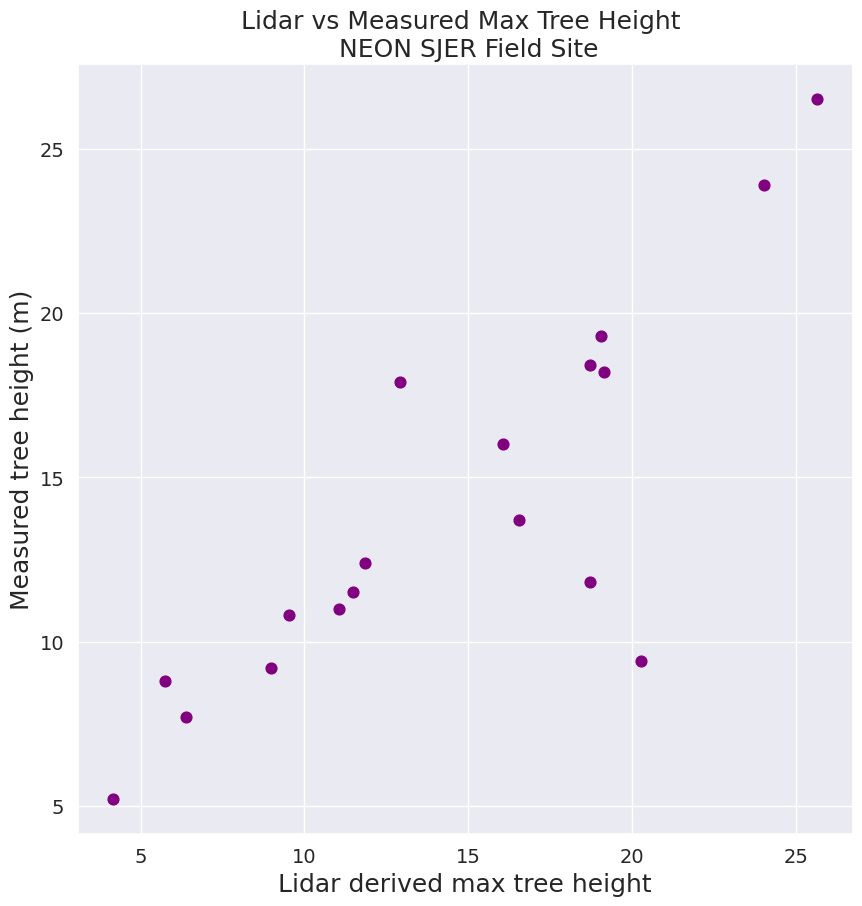

In [9]:
sjer_final_height_df = pd.DataFrame(sjer_final_height)

fig, ax = plt.subplots(figsize=(10, 10))

sjer_final_height_df.plot('lidar_max',
                          'insitu_max',
                          kind='scatter',
                          fontsize=14, s=60,
                          color="purple",
                          ax=ax)

ax.set(xlabel="Lidar derived max tree height",
       ylabel="Measured tree height (m)",
       title="Lidar vs Measured Max Tree Height \n NEON SJER Field Site")

plt.show()

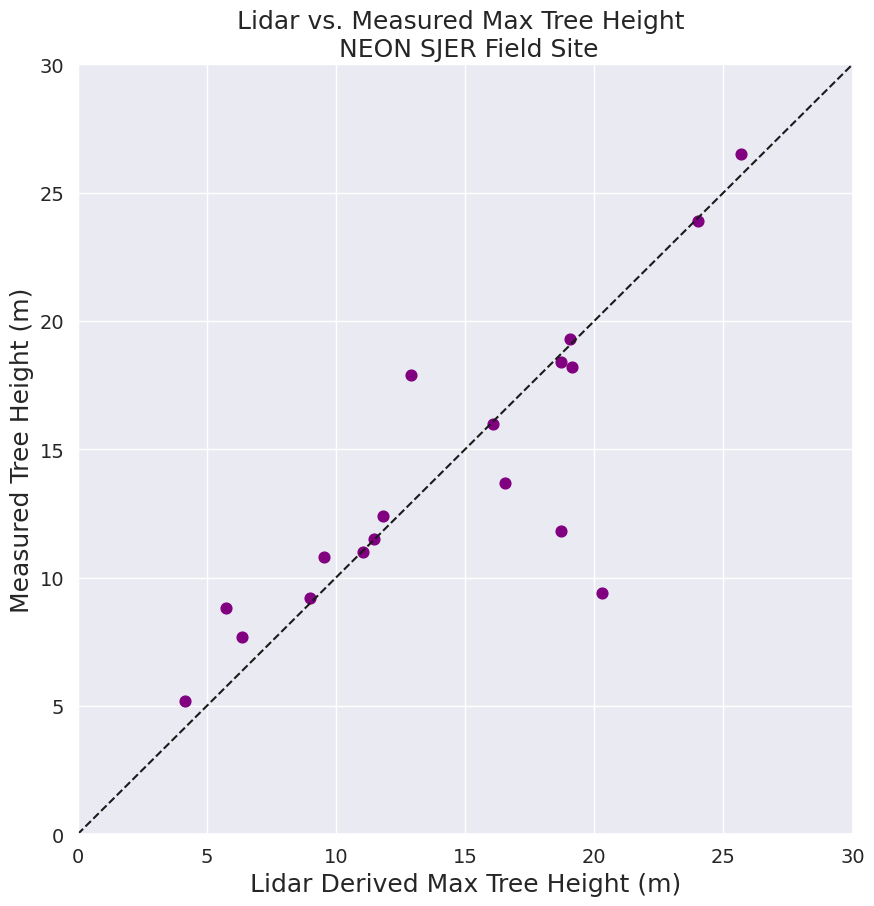

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

sjer_final_height_df.plot('lidar_max',
                          'insitu_max',
                          kind='scatter',
                          fontsize=14,
                          color="purple",
                          s=60, ax=ax)

ax.set(xlabel="Lidar Derived Max Tree Height (m)",
       ylabel="Measured Tree Height (m)",
       title="Lidar vs. Measured Max Tree Height \n NEON SJER Field Site")

ax.plot((0, 1), (0, 1),
        transform=ax.transAxes, ls='--', c='k')

ax.set(xlim=[0, 30], ylim=[0, 30])
plt.show()

In [11]:
outpath = os.path.join("spatial-vector-lidar",
                       "outputs",
                       "sjer-lidar-insitu-merge.csv")

sjer_final_height_df.to_csv(outpath)